Libraries and setup

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd
import folium
import os
from haversine import haversine, Unit
import glob

from yellow import trips as yt
from bikescience import load_trips as tr
from bikescience import sp_grid
from bikescience.yellow_flow import od_countings
from bikescience.flow import load_flow_file, flow_map
from bikescience.tiers import separate_into_tiers

od_id = ['i_start', 'j_start', 'i_end', 'j_end']
folder = '../../../data/sao-paulo/training-sets/processing/'

Trips

In [2]:
trips = pd.read_csv('~/saida.csv')
trips['starttime'] = yt.extract_start_times(trips)
tr.create_time_features(trips)

In [3]:
grid = sp_grid.create(n=40, west_offset=-.1, east_offset=.01, north_offset=.01, south_offset=-.1)

Estimating coverage area to avoid bias

In [5]:
od = od_countings(trips, grid)
od.head()

/usr/local/lib/python3.5/dist-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  '(%s != %s)' % (left_df.crs, right_df.crs))


i_start  j_start  i_end  j_end  trip counts  \
0        0        0      0      0            1   
1        0        1      0      1            1   
2        0        2      0      2           10   
3        0        2      1      5            3   
4        0        2      8     18            1   

                                          origin  \
0  POINT (-46.73866653442383 -23.64823341369629)   
1  POINT (-46.73553848266602 -23.64707183837891)   
2   POINT (-46.73183032748064 -23.6479828363181)   
3  POINT (-46.73125966389974 -23.64714495340983)   
4  POINT (-46.73173904418945 -23.64858818054199)   

                                     destination  
0                POINT (-46.7386674 -23.6482338)  
1   POINT (-46.73545455932617 -23.6471004486084)  
2   POINT (-46.73182706946913 -23.6479812040838)  
3  POINT (-46.72428766886393 -23.64505449930827)  
4  POINT (-46.68772506713867 -23.62649917602539)

In [20]:
start_counts = grid.geodataframe() \
                   .merge(od, left_on=('i', 'j'), right_on=('i_start', 'j_start')) \
                   .groupby(['i', 'j'], as_index=False).agg({'trip counts': 'sum'}) \
                   .merge(grid.geodataframe())
start_counts = gpd.GeoDataFrame(start_counts)
start_counts.head()

i  j  trip counts                                           geometry
0  0  0            1  POLYGON ((-46.73605000000001 -23.6489, -46.736...
1  0  1            1  POLYGON ((-46.73330000000001 -23.6489, -46.733...
2  0  2           15  POLYGON ((-46.73055000000001 -23.6489, -46.730...
3  0  3            1  POLYGON ((-46.7278 -23.6489, -46.7278 -23.6461...
4  0  4           24  POLYGON ((-46.72505 -23.6489, -46.72505 -23.64...

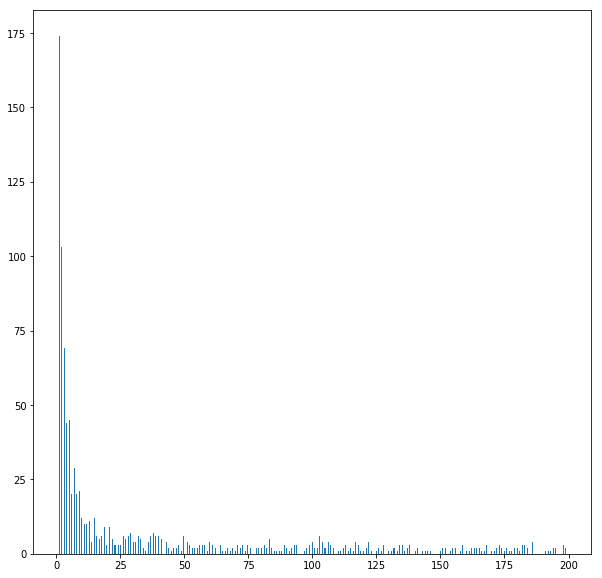

In [22]:
stat = start_counts['trip counts']
plt.figure(figsize=(10, 10))
plt.hist(stat[stat < 200], bins=500)
plt.show()

In [42]:
filtered_cells = start_counts[start_counts['trip counts'] >= 20].copy()
max_count = filtered_cells['trip counts'].max()
fmap = grid.map_around(plot_grid=False)
for idx, row in filtered_cells.iterrows():
    rect = row.geometry.bounds
    folium.Rectangle([[rect[1], rect[0]], [rect[3], rect[2]]],
                     fill=True,
                     fill_opacity=row['trip counts'] / max_count,
                     weight=1, 
                     popup='i: ' + str(row.i) + ' / j: ' + str(row.j)).add_to(fmap)
fmap

In [52]:
dist_cache = {}

def calc_distance(row):
    inverse = (row.i_end, row.j_end, row.i_start, row.j_start)
    if inverse in dist_cache:
        return dist_cache[inverse]
    distance = haversine((row.origin.y, row.origin.x), (row.destination.y, row.destination.x), unit=Unit.METERS)
    dist_cache[(row.i_start, row.j_start, row.i_end, row.j_end)] = distance
    return distance

filtered_cells['fake_id'] = 42
combinations = filtered_cells.merge(filtered_cells, on='fake_id', suffixes=('_start', '_end'))
combinations['origin'] = combinations.geometry_start.apply(lambda cell: cell.centroid)
combinations['destination'] = combinations.geometry_end.apply(lambda cell: cell.centroid)
combinations['distance'] = combinations.apply(calc_distance, axis=1)
combinations = combinations[od_id + ['origin', 'destination', 'distance']]
combinations.head()

i_start  j_start  i_end  j_end                                 origin  \
0        0        4      0      4  POINT (-46.72642500000001 -23.647525)   
1        0        4      0      5  POINT (-46.72642500000001 -23.647525)   
2        0        4      0      6  POINT (-46.72642500000001 -23.647525)   
3        0        4      0      7  POINT (-46.72642500000001 -23.647525)   
4        0        4      0      8  POINT (-46.72642500000001 -23.647525)   

                             destination     distance  
0  POINT (-46.72642500000001 -23.647525)     0.000000  
1          POINT (-46.723675 -23.647525)   280.109684  
2  POINT (-46.72092500000001 -23.647525)   560.219368  
3          POINT (-46.718175 -23.647525)   840.329052  
4          POINT (-46.715425 -23.647525)  1120.438736

Flow sampling
* Month
* Day period (morning, lunchtime, afternoon)
* Day type (work day, weekend/holiday)

In [48]:
trips['month'] = trips.starttime.dt.to_period('m').dt.to_timestamp()
months = trips.month.unique()
months

array(['2018-08-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000',
       '2018-12-01T00:00:00.000000000', '2019-01-01T00:00:00.000000000',
       '2018-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [75]:
period_names = ['morning', 'lunchtime', 'afternoon']
periods = [tr.morning(trips), tr.lunchtime(trips), tr.afternoon(trips)]
idx = 0

for period in periods:
    print('Period:', period_names[idx])
    for month in months:
        month_str = pd.to_datetime(month).strftime('%Y%m')
        print('   Month:', month_str)
        for weekend in [False, True]:
            weekend_str = 'weekend-holiday' if weekend else 'working-day'
            print('      ', weekend_str)
            csv = folder + 'tmp/' + month_str + '-' + period_names[idx] + '-' + weekend_str + '.csv'
            if os.path.isfile(csv): 
                print('       --- already processed')
                continue
            weekend_filter = (period.weekend | period.holiday) if weekend else ~(period.weekend | period.holiday)
            filtered = period[(period.month == month) & weekend_filter]
            print(len(filtered))
            if len(filtered) <= 2: continue
            od = od_countings(filtered, grid)
            od = od[od_id + ['trip counts']]
            od = combinations.merge(od, on=od_id, how='left').fillna(0)
            od = od[(od.i_start != od.i_end) | (od.j_start != od.j_end)]
            od['period'] = idx
            od['month'] = month
            od['weekend_or_holiday'] = 1 if weekend else 0
            od.drop(columns=['origin', 'destination'], inplace=True)
            od.to_csv(csv, index=False)
    idx += 1

Period: morning
   Month: 201808
       working-day
       --- already processed
       weekend-holiday
       --- already processed
   Month: 201809
       working-day
       --- already processed
       weekend-holiday
       --- already processed
   Month: 201810
       working-day
       --- already processed
       weekend-holiday
       --- already processed
   Month: 201811
       working-day
       --- already processed
       weekend-holiday
       --- already processed
   Month: 201812
       working-day
       --- already processed
       weekend-holiday
       --- already processed
   Month: 201901
       working-day
       --- already processed
       weekend-holiday
       --- already processed
   Month: 201807
       working-day
       --- already processed
       weekend-holiday
2
Period: lunchtime
   Month: 201808
       working-day
       --- already processed
       weekend-holiday
       --- already processed
   Month: 201809
       working-day
       --- already pr

In [2]:
od_files = glob.glob(folder + 'tmp/*.csv')
od_list = []

for f in od_files:
    od = pd.read_csv(f)
    od_list.append(od)

od_samples = pd.concat(od_list, sort=False)
od_samples.to_csv(folder + 'flows.csv', index=False)
print(len(od_samples), 'flows')
od_samples.head(20)

21343042 flows


i_start  j_start  i_end  j_end     distance  trip counts  period  \
0         0        4      0      5   280.109684          0.0       0   
1         0        4      0      6   560.219368          0.0       0   
2         0        4      0      7   840.329052          0.0       0   
3         0        4      0      8  1120.438736          0.0       0   
4         0        4      0      9  1400.548419          0.0       0   
5         0        4      0     10  1680.658103          0.0       0   
6         0        4      0     11  1960.767786          0.0       0   
7         0        4      0     12  2240.877470          0.0       0   
8         0        4      0     13  2520.987153          0.0       0   
9         0        4      1      1   894.244442          0.0       0   
10        0        4      1      2   638.245800          0.0       0   
11        0        4      1      4   305.786471          0.0       0   
12        0        4      1      5   414.690788          0.0       0   
13        0        4      1      6   638.245800          0.0       0   
14        0        4      1      7   894.244442          0.0       0   
15        0        4      1      8  1161.427875          0.0       0   
16        0        4      1      9  1433.555881          0.0       0   
17        0        4      1     10  1708.267071          0.0       0   
18        0        4      1     12  2261.668130          0.0       0   
19        0        4      1     13  2539.491121          0.0       0   

         month  weekend_or_holiday  
0   2018-10-01                   1  
1   2018-10-01                   1  
2   2018-10-01                   1  
3   2018-10-01                   1  
4   2018-10-01                   1  
5   2018-10-01                   1  
6   2018-10-01                   1  
7   2018-10-01                   1  
8   2018-10-01                   1  
9   2018-10-01                   1  
10  2018-10-01                   1  
11  2018-10-01                   1  
12  2018-10-01                   1  
13  2018-10-01                   1  
14  2018-10-01                   1  
15  2018-10-01                   1  
16  2018-10-01                   1  
17  2018-10-01                   1  
18  2018-10-01                   1  
19  2018-10-01                   1